In [1]:
%matplotlib inline

# Skin Lesion Akida Prototype

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os, shutil, random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.layers import Activation, Dropout, Reshape
from akida_models.layer_blocks import dense_block
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from quantizeml.models import quantize, QuantizationParams, dump_config
from timeit import default_timer as timer
from cnn2snn import convert
from tensorflow.keras.models import load_model
from akida_models import load_model
import matplotlib.lines as lines
from akida_models.imagenet import preprocessing

In [3]:
# combine the two parts of the dataset into one folder
def combine_folders(source_folders, target_folder):
    os.makedirs(target_folder, exist_ok=True)

    for folder in source_folders:
        file_names = os.listdir(folder)
        for file_name in file_names:
            source_file_path = os.path.join(folder, file_name)
            if os.path.isfile(source_file_path):
                target_file_path = os.path.join(target_folder, file_name)
                shutil.copy(source_file_path, target_file_path)

source_folders = ['archive/HAM10000_images_part_1', 'archive/HAM10000_images_part_2']
target_folder = 'archive/data'
combine_folders(source_folders, target_folder)

In [4]:
metadata = pd.read_csv('archive/HAM10000_metadata.csv')

from sklearn.model_selection import train_test_split
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(target_folder, f"{x}.jpg"))
train_data, test_data = train_test_split(metadata, random_state=17, stratify=metadata.dx, test_size=0.10)

print(test_data['dx'].value_counts())
print(test_data.shape)

train_data = train_data.set_index("image_id")
test_data = test_data.set_index("image_id")

train_id = list(train_data.index)
test_id = list(test_data.index)

dx
nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: count, dtype: int64
(1002, 8)


In [5]:
dirs = []

# Create train and test directory
train_dir = os.path.join('archive/data/', "train")
dirs.append(train_dir)
test_dir = os.path.join('archive/data/', "test")
dirs.append(test_dir)

# Create training subfolders for diagnoses
train_nv = os.path.join(train_dir, "nv")
dirs.append(train_nv)
train_mel = os.path.join(train_dir, "mel")
dirs.append(train_mel)
train_bkl = os.path.join(train_dir, "bkl")
dirs.append(train_bkl)
train_bcc = os.path.join(train_dir, "bcc")
dirs.append(train_bcc)
train_akiec = os.path.join(train_dir, "akiec")
dirs.append(train_akiec)
train_vasc = os.path.join(train_dir, "vasc")
dirs.append(train_vasc)
train_df = os.path.join(train_dir, "df")
dirs.append(train_df)

# Create validation subfolders for diagnoses
validation_nv = os.path.join(test_dir, "nv")
dirs.append(validation_nv)
validation_mel = os.path.join(test_dir, "mel")
dirs.append(validation_mel)
validation_bkl = os.path.join(test_dir, "bkl")
dirs.append(validation_bkl)
validation_bcc = os.path.join(test_dir, "bcc")
dirs.append(validation_bcc)
validation_akiec = os.path.join(test_dir, "akiec")
dirs.append(validation_akiec)
validation_vasc = os.path.join(test_dir, "vasc")
dirs.append(validation_vasc)
validation_df = os.path.join(test_dir, "df")
dirs.append(validation_df)

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [6]:
# move images to train and test dirs
target_folder = 'archive/data'
files = os.listdir(target_folder)

for image in train_id:
    file_name = str(image + '.jpg')
    label = train_data.loc[image,'dx']

    if file_name in files:
        src = os.path.join(target_folder, file_name)
        dst = os.path.join(train_dir, label, file_name)
        shutil.copyfile(src, dst)

for image in test_id:

    file_name = image + '.jpg'
    label = test_data.loc[image,'dx']

    if file_name in files:
        src = os.path.join(target_folder, file_name)
        dst = os.path.join(test_dir, label, file_name)
        shutil.copyfile(src, dst)

In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode='sparse',
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode='sparse'
)

IMG_SIZE = 224
CLASSES = 7


Found 9013 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [8]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Create a Dataset from the generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

train_dataset = train_dataset.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)

# Define batch size and batch the dataset
BATCH_SIZE = 32
train_batches = train_dataset.unbatch().batch(BATCH_SIZE)

In [9]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

test_dataset = test_dataset.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)

# Define batch size and batch the dataset
BATCH_SIZE = 32
test_batches = test_dataset.unbatch().batch(BATCH_SIZE)

In [10]:
def generator_to_numpy(generator):
    images_list = []
    labels_list = []

    # Iterate through the generator
    for _ in range(len(generator)):
        images, labels = generator.next()
        images_list.append(images)
        labels_list.append(labels)

    # Concatenate lists into numpy arrays
    x_test = np.concatenate(images_list, axis=0)
    labels_test = np.concatenate(labels_list, axis=0)

    return x_test, labels_test

# Example usage with test_gen
x_test, labels_test = generator_to_numpy(test_gen)

# Ensure the shapes are correct
print(x_test.shape)  # Should be (num_samples, 224, 224, 3)
print(labels_test.shape)  # Should be (num_samples,)

(1002, 224, 224, 3)
(1002,)


In [11]:
model_path = 'models/model_akida.fbz'
model = load_model(model_path)

model.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [1, 1, 7]     1          27    
________________________________________________

_____________________________________________________________________
Layer (type)                       Output shape    Kernel shape    

================== SW/conv_0-dequantizer (Software) =================

conv_0 (InputConv2D)               [112, 112, 16]  (3, 3, 3, 16)   
_____________________________________________________________________
conv_1 (Conv2D)                    [112, 112, 32]  (3, 3, 16, 32)  
_____________________________________________________________________
conv_2 (Conv2D)                    [56, 56, 64]    (3, 3, 32, 64)  
_____________________________________________________________________
conv_3 (Conv2D)                    [56, 56, 64]    (3, 3, 64, 64)  
__________________________________________________________________

In [12]:
from timeit import default_timer as timer

# Check Model performance
num_images = len(x_test)
start = timer()
accuracy_akida = model.evaluate(x_test, labels_test)
end = timer()
print(f'Inference on {num_images} images took {end-start:.2f} s.\n')
print(f"Accuracy: {accuracy_akida*num_images:.0f}/{num_images}.")

Inference on 1002 images took 62.71 s.

Accuracy: 671/1002.


In [13]:
class_indices = test_gen.classes

# Get the mapping from class names to indices
class_indices_mapping = test_gen.class_indices

# Create a reverse mapping from indices to class names
index_to_class = {v: k for k, v in class_indices_mapping.items()}

# Count the number of samples for each class
class_counts = np.bincount(class_indices)

# Print the number of samples for each class
print("Number of samples:", test_gen.samples)
print("Number of samples per class in the test generator:")
for class_index, count in enumerate(class_counts):
    class_name = index_to_class[class_index]
    print(f"{class_name}: {count}")

Number of samples: 1002
Number of samples per class in the test generator:
akiec: 33
bcc: 51
bkl: 110
df: 12
mel: 111
nv: 671
vasc: 14


Akida outputs: [-5.5879674 -2.6575031 -1.4395865 -1.3195293 -6.0729647  9.164673
 -1.536442 ]
True label: nv
Predicted label: nv


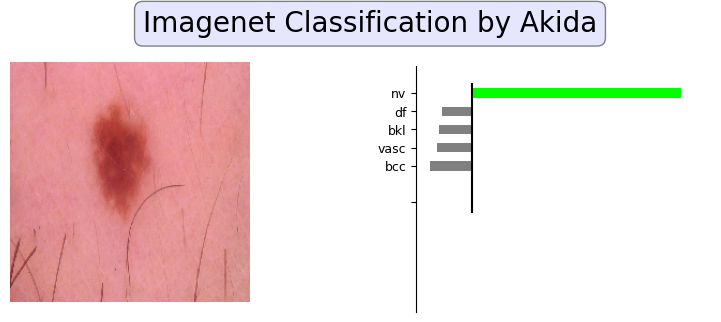

In [19]:
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

NUM_CHANNELS = 3

# Functions used to display the top5 results
def get_top5(potentials, true_label):
    """
    Returns the top 5 classes from the output potentials
    """
    tmp_pots = potentials.copy()
    top5 = []
    min_val = np.min(tmp_pots)
    for ii in range(5):
        best = np.argmax(tmp_pots)
        top5.append(best)
        tmp_pots[best] = min_val

    vals = np.zeros((6,))
    vals[:5] = potentials[top5]

    if true_label not in top5:
        vals[5] = potentials[true_label]
    else:
        vals[5] = 0

    vals /= np.max(vals)

    class_name = []
    for ii in range(5):
        class_name.append(class_names[top5[ii]])
    if true_label in top5:
        class_name.append('')
    else:
        class_name.append(
            class_names[true_label])

    return top5, vals, class_name


def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])


def prepare_plots():
    fig = plt.figure(figsize=(8, 4))
    # Image subplot
    ax0 = plt.subplot(1, 3, 1)
    imgobj = ax0.imshow(np.zeros((IMG_SIZE, IMG_SIZE, NUM_CHANNELS), dtype=np.uint8))
    ax0.set_axis_off()
    # Top 5 results subplot
    ax1 = plt.subplot(1, 2, 2)
    bar_positions = (0, 1, 2, 3, 4, 6)
    rects = ax1.barh(bar_positions, np.zeros((6,)), align='center', height=0.5)
    plt.xlim(-0.2, 1.01)
    ax1.set(xlim=(-0.2, 1.15), ylim=(-1.5, 12))
    ax1.set_yticks(bar_positions)
    ax1.invert_yaxis()
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks([])
    adjust_spines(ax1, 'left')
    ax1.add_line(lines.Line2D((0, 0), (-0.5, 6.5), color=(0.0, 0.0, 0.0)))
    # Adjust Plot Positions
    ax0.set_position([0.05, 0.055, 0.3, 0.9])
    l1, b1, w1, h1 = ax1.get_position().bounds
    ax1.set_position([l1 * 1.05, b1 + 0.09 * h1, w1, 0.8 * h1])
    # Add title box
    plt.figtext(0.5,
                0.9,
                "Imagenet Classification by Akida",
                size=20,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round",
                          ec=(0.5, 0.5, 0.5),
                          fc=(0.9, 0.9, 1.0)))

    return fig, imgobj, ax1, rects


def update_bars_chart(rects, vals, true_label):
    counter = 0
    for rect, h in zip(rects, yvals):
        rect.set_width(h)
        if counter < 5:
            if top5[counter] == true_label:
                if counter == 0:
                    rect.set_facecolor((0.0, 1.0, 0.0))
                else:
                    rect.set_facecolor((0.0, 0.5, 0.0))
            else:
                rect.set_facecolor('gray')
        elif counter == 5:
            rect.set_facecolor('red')
        counter += 1


# Prepare plots
fig, imgobj, ax1, rects = prepare_plots()

# Get a random image
img = np.random.randint(num_images)

# Predict image class
outputs_akida = model.predict(np.expand_dims(x_test[img].astype(np.uint8), axis=0)).squeeze()

# Get top 5 prediction labels and associated names
true_label = labels_test[img]
top5, yvals, class_name = get_top5(outputs_akida, true_label)

print("Akida outputs:", outputs_akida)
print("True label:", class_names[int(true_label)])
print("Predicted label:", class_names[np.argmax(outputs_akida)])

# Draw Plots
imgobj.set_data(x_test[img])
ax1.set_yticklabels(class_name, rotation='horizontal', size=9)
update_bars_chart(rects, yvals, true_label)
fig.canvas.draw()
plt.show()